In [1]:
# Import classes for generating sequences
import torch
from torch import nn
import numpy as np
from GenerateVT import GenerateVT
from MassFricParams import MassFricParams
from TimeSequenceGen import TimeSequenceGen
from TimeSequenceGen_NN import TimeSequenceGen_NN
from matplotlib import pyplot as plt
from matplotlib import rc
from FrictionNNModels import plotGenVXFric, relativeL2
import time
# For plotting
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [2]:
# Generating a VT sequence for the spring slider
VTkwgs = {
        'logVDist' : True, 
        'Vrange' : [-2., 1.], 
        'Trange' : [0., 2.0], 
        'NofTpts' : 10, 
        'flag' : 'simple', 
        'nOfTerms' : 3, 
}
myVT = GenerateVT(VTkwgs)

In [34]:
# Generate a time sequence
# Spring slider parameters
kmg = [5000., 1., 9.8]

# Rate and state parameters
RSParams = [0.011, 0.016, 1. / 1.e-2, 0.58]

# Solver specific parameters
rtol, atol = 1.e-8, 1.e-10 
regularizedFlag = False

# Solver-specific settings
# solver = 'dopri5'
solver = 'rk4'
max_iters = 20
# step_sizes = [pow(2., i) for i in np.linspace(-15, -11, num = 2)]
step_sizes = [0.002]

# Store the results
Frics = []
Vs = []
xs = []
legends = ["$\Delta t = {0}$ s".format(step_size) for step_size in step_sizes]

## Loop thru all step_sizes
for step_size in step_sizes:
    solver_options = {
        'max_iters' : max_iters, 
        'step_size' : step_size, 
    }

    # Initial condition
    y0 = torch.tensor([0., 1., 1. / RSParams[2]])
    myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = regularizedFlag)

    # Start timer
    st = time.time()

    # Set for my sequence
    myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                rtol, 
                                atol, 
                                regularizedFlag, 
                                solver, 
                                solver_options)
    
    Vs.append(myTimeSeq.default_y[1, :])
    xs.append(myTimeSeq.default_y[0, :])
    Frics.append(myTimeSeq.Fric)
    print("-"* 25, " Dt = {0}, {1} s.".format(step_size, time.time() - st), "-"* 25)


/home/shengduo/anaconda3/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: RK4: Unexpected arguments {'max_iters': 20}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


-------------------------  Dt = 0.002, 1.059201955795288 s. -------------------------


In [2]:
# Try loading the model
# Load the learnt model from storage
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, FricCorrection, load_model

modelPrefix = "Trial0216_combined_800"
# modelPrefix = "Trial0517_combined_800"
# modelPrefix = "Trial_0216_0521SS_400"
# modelPrefix = "Trial0216_smallDRS_smallA_400"
dim_xi = 1

# Get correct device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

myModel = load_model(modelPrefix, device, dim_xi, True, NN_Flag=1)

In [36]:
# Solver-specific settings
# solver = 'dopri5'
solver = 'rk4'
max_iters = 20

# step_sizes = [pow(2., i) for i in np.linspace(-12, -11, num = 2)]
step_sizes = [0.002]

# Store the results
Fric_NNs = []
V_NNs = []
x_NNs = []
legend_NNs = ["$\Delta t = {0}$ s".format(step_size) for step_size in step_sizes]

for step_size in step_sizes:
    solver_options = {
        'max_iters' : max_iters, 
        'step_size' : step_size, 
    }

    # Start the timer
    st = time.time()
    
    # Compute slip rate for the same input sequence using NN model
    myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                    10, 
                                    myMFParams, 
                                    myModel, 
                                    rtol, 
                                    atol, 
                                    solver, 
                                    solver_options,  
                                    fOffSet = 0.5109, 
                                    scaling_factor = 50.)

    V_NNs.append(myTimeSeqNN.default_y[1, :])
    x_NNs.append(myTimeSeqNN.default_y[0, :])
    Fric_NNs.append(myTimeSeqNN.Fric)
    print("-"* 25, " Dt = {0}, {1} s.".format(step_size, time.time() - st), "-"* 25)

-------------------------  Dt = 0.002, 53.17613983154297 s. -------------------------


Text(0.5, 0.98, 'Sequence 0')

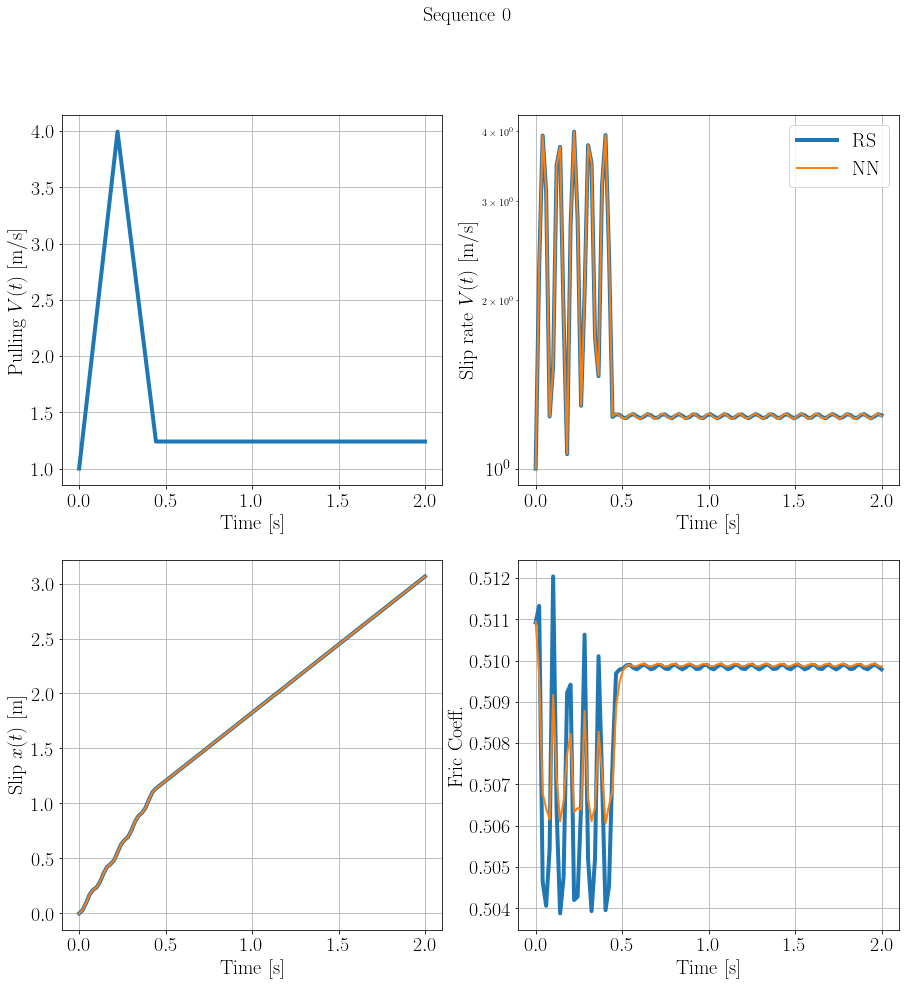

In [37]:
# Plot the two sequences
f, axs = plotGenVXFric(myVT.VT[0, :], myVT.VT[1, :], myTimeSeq.t, 
                       [myTimeSeq.default_y[1, :], myTimeSeqNN.default_y[1, :]], 
                       [myTimeSeq.default_y[0, :], myTimeSeqNN.default_y[0, :]], 
                       [myTimeSeq.Fric, myTimeSeqNN.Fric],
                       legends=["RS", "NN"])
f.suptitle("Sequence {0}".format(0), fontsize=20)

# Test on more sequences


In [5]:
import random

# Store the results
NofSeqs = 10
y_RSs = []
y_NNs = []
Fric_RSs = []
Fric_NNs = []
myVTs = []
ks = []
ts = []

# Set up solver info
solver = 'rk4'
solver_options = dict()
regularizedFlag = False
load_sequences = True
loadDir = "./data/testSpringSlider0521_10.pt"
loadedData = torch.load(loadDir)

VTkwgs = {
        'logVDist' : True, 
        'Vrange' : [-2., 1.], 
        'Trange' : [0., 0.5], 
        'NofTpts' : 10, 
        'flag' : 'simple', 
        'nOfTerms' : 3, 
}

# Rate and state parameters
RSParams = [0.011, 0.016, 1. / 1.e-2, 0.58]

# Solver specific parameters
rtol, atol = 1.e-8, 1.e-10 
regularizedFlag = False

y0 = torch.tensor([0., 1., 1. / RSParams[2]])

# Start generating sequences
id = 0
while id < NofSeqs:
    if load_sequences == True:
        k = loadedData['ks'][id]
        kmg = [k, 1., 9.8]
        myVT = loadedData['myVTs'][id]
    else:
        k = 10. ** (random.random() * 3. + 1.)
        kmg = [k, 1., 9.8]
        myVT = GenerateVT(VTkwgs)
    myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = regularizedFlag)

    # Set for my sequence
    myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                rtol, 
                                atol, 
                                regularizedFlag, 
                                solver, 
                                solver_options)
    
    # Check if there is nan in myTimeSeq
    if torch.any(torch.isnan(myTimeSeq.default_y)):
        continue

    # Store the results
    y_RSs.append(myTimeSeq.default_y)
    Fric_RSs.append(myTimeSeq.Fric)
    
    # Compute slip rate for the same input sequence using NN model
    myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                        10, 
                                        myMFParams, 
                                        myModel, 
                                        rtol, 
                                        atol, 
                                        solver,
                                        solver_options,
                                        fOffSet = 0.5109, 
                                        scaling_factor = 50.)
    
    # Check if there is nan in myTimeSeqNN
    if torch.any(torch.isnan(myTimeSeqNN.default_y)):
        continue
    
    # Store the results
    y_NNs.append(myTimeSeqNN.default_y)
    Fric_NNs.append(myTimeSeqNN.Fric)

    myVTs.append(myVT)
    ks.append(k)
    ts.append(myTimeSeq.t)

    # Update id
    id += 1
    if id % 10 == 0:
        print("Finished sampling {0} sequences.".format(id), flush=True)

Finished sampling 10 sequences.


In [6]:
# save results
res = {
    'y_RSs' : y_RSs, 
    'y_NNs' : y_NNs, 
    'Fric_RSs' : Fric_RSs, 
    'Fric_NNs' : Fric_NNs, 
    'myVTs' : myVTs, 
    'ks' : ks, 
    'RSParams' : RSParams,
    'rtol' : rtol, 
    'atol' : atol,
    'ts' : ts, 
    'regularizedFlag' : regularizedFlag, 
    'solver' : solver, 
}
torch.save(res, "./data/testSpringSlider0527_10_trial0216_combined_800.pt")

# Vs = torch.stack([y_RS[1, :] for y_RS in y_RSs])
# thetas = torch.stack([y_RS[2, :] for y_RS in  y_RSs])
# fs = torch.stack(Fric_RSs)
# ts = torch.stack(ts)

# asTrainingData = {
#     "Vs" : Vs, 
#     "thetas" : thetas, 
#     "fs" : fs, 
#     "ts" : ts, 
# }

# print("Vs.shape: ", Vs.shape)
# print("thetas.shape: ", thetas.shape)
# print("fs.shape: ", fs.shape)
# print("ts.shape: ", ts.shape)

# torch.save(asTrainingData, './data/SpringSlider0521_400.pt')

In [4]:
# Report relative L-2 error on friction coefficient, slip rate on the slider
res = torch.load('./data/testSpringSlider0527_10_trial0216_combined_800.pt')
res1 = torch.load('./data/testSpringSlider0527_10_trial0216_0521SS_combined_800.pt')
# Report relative L2 error in x, V, and friction
err_x = []
err_V = []
err_Fric = []
fOffSet, scaling_factor = 0.5109, 50.

for i in range(len(res['ks'])):
    this_NN_Fric = (res['Fric_NNs'][i] - fOffSet) * scaling_factor + fOffSet
    this_RS_Fric = (res['Fric_RSs'][i] - fOffSet) * scaling_factor + fOffSet

    err_x.append(relativeL2(res['y_NNs'][i][0, :], res['y_RSs'][i][0, :], res['ts'][i]))
    err_V.append(relativeL2(res['y_NNs'][i][1, :], res['y_RSs'][i][1, :], res['ts'][i]))
    err_Fric.append(relativeL2(this_NN_Fric, this_RS_Fric, res['ts'][i]))

# Err into tensors
err_x = torch.stack(err_x)
err_V = torch.stack(err_V)
err_Fric = torch.stack(err_Fric)

# Report the mean and standard deviation in L2 errors
std, mean = torch.std_mean(err_x)
print("Mean, std of L2 error in x: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(err_V)
print("Mean, std of L2 error in V: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(err_Fric)
print("Mean, std of L2 error in Friction: {0}, {1}".format(mean, std))


Mean, std of L2 error in x: 1.9012726625078358e-05, 1.831612280511763e-05
Mean, std of L2 error in V: 0.0002725660160649568, 0.00036303349770605564
Mean, std of L2 error in Friction: 0.030255991965532303, 0.02447669766843319


# Plot the error distribution of x, V and Friction

NameError: name 'err_x' is not defined

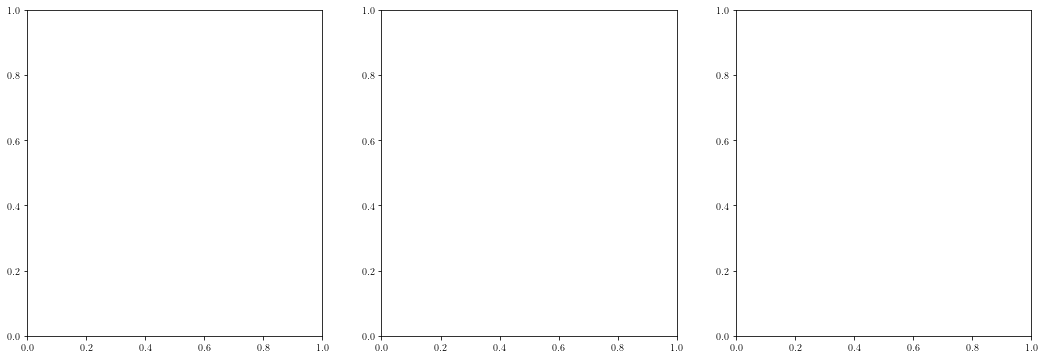

In [13]:
# Set up histograms
fsize = 20
fig, axs = plt.subplots(ncols = 3, figsize = (18, 6))
nBins = 10
hist_data = [err_x, err_V, err_Fric]
hist_xlabels = ["$Err(x)$", "$Err(V)$", "$Err(f)$"]

# Loop through dataPrefixs
for idx, (h_data, h_xlabel) in enumerate(zip(hist_data, hist_xlabels)):
    axs[idx].tick_params(axis='both', which='major', labelsize=fsize)
    axs[idx].hist(h_data.detach().numpy(), bins=nBins, density=True)
    axs[idx].set_xlabel(h_xlabel, fontsize=fsize)
    axs[idx].set_ylabel("pdf", fontsize=fsize)

# Plot an example sequence

Text(0.5, 0.98, 'Sequence 9')

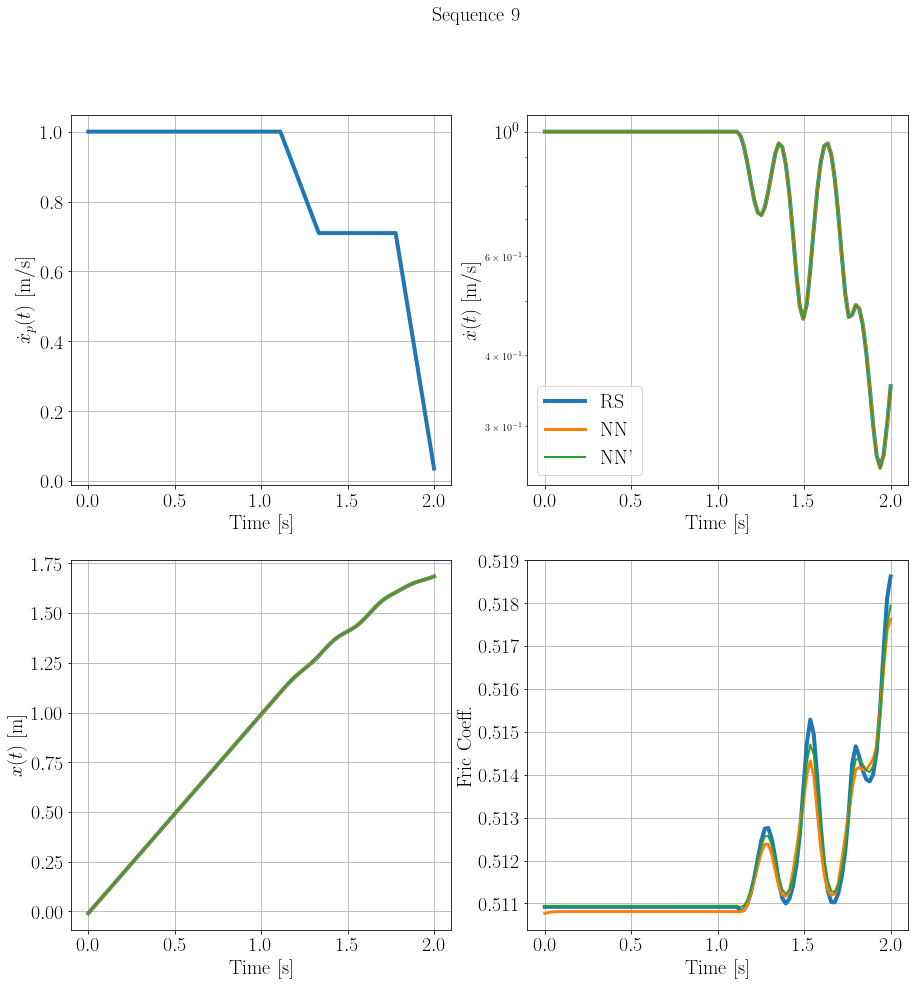

In [8]:
# Plot a sequence
# Plot the sequences from NN and rate-and-state friction on the same plot
import random
NofSeqs = 10

# Plot a sequence
idx = random.randint(0, NofSeqs - 1)
idx = 9
VV, tt = res['myVTs'][idx].VT[0, :], res['myVTs'][idx].VT[1, :]
t = res['ts'][idx]
Vs = [res['y_RSs'][idx][1, :], res['y_NNs'][idx][1, :], res1['y_NNs'][idx][1, :]]
xs = [res['y_RSs'][idx][0, :], res['y_NNs'][idx][0, :], res1['y_NNs'][idx][0, :]]
Frics = [res['Fric_RSs'][idx], res['Fric_NNs'][idx], res1['Fric_NNs'][idx]]
f, axs = plotGenVXFric(VV, tt, t, Vs, xs, Frics, legends=["RS", "NN", "NN'"])
f.suptitle("Sequence {0}".format(idx), fontsize=20)

In [9]:
f.savefig("./plots/pdf_figures/SS_seq9_0216_0521SS_combined_800.pdf", format="pdf", bbox_inches="tight")

# Load sequences with "rk" and "implicit_adams"

In [19]:
# Loop through all sequences, compute relative error
# PATH = "./data/RSvsNNSpringSliderAcc0522_fine/"
PATH = "./data/RSvsNNSpringSliderAcc0531_fine/"
fore_names = ["res_NN_im_seq", "res_NN_ex_seq", "res_RS_im_reg_seq", "res_RS_ex_reg_seq"]
legends = ["NN, implicit", "NN, explicit", "RS, implicit", "RS, explicit"]
markers = ['-s', '--s', '-o', '--o']
colors = ['tab:blue', 'tab:blue', 'tab:green', 'tab:green']
NofSeqs = 77

# Store all err, declare whether or not using logV in the L2 error
logVFlag = False
rel_err_Vs = [[] for i in range(len(fore_names))]
rel_err_xs = [[] for i in range(len(fore_names))]
rel_err_Frics = [[] for i in range(len(fore_names))]

for i in range(NofSeqs):
    for idx, fore_name in enumerate(fore_names):
        res = torch.load(PATH + fore_name + "_{0}.pth".format(i))
        if len(res['Vs']) > len(res['step_sizes']):
            res['Vs'] = [res['Vs'][i] for i in range(len(res['Vs']) - len(res['step_sizes']), len(res['Vs']))]
            res['xs'] = [res['xs'][i] for i in range(len(res['xs']) - len(res['step_sizes']), len(res['xs']))]
            res['Frics'] = [res['Frics'][i] for i in range(len(res['Frics']) - len(res['step_sizes']), len(res['Frics']))]
        this_err_logV = []
        this_err_x = []
        this_err_Fric = []
        for j in range(1, len(res['Vs'])):
            if logVFlag == True:
                this_err_logV.append(relativeL2(torch.log10(torch.abs(res['Vs'][j])), 
                                                torch.log10(torch.abs(res['Vs'][0])), 
                                                res['t']))
            else:
                this_err_logV.append(relativeL2(res['Vs'][j], 
                                                res['Vs'][0], 
                                                res['t']))

            this_err_x.append(relativeL2(res['xs'][j], res['xs'][0], res['t']))
            this_err_Fric.append(relativeL2(res['Frics'][j], res['Frics'][0], res['t']))
        rel_err_Vs[idx].append(this_err_logV)
        rel_err_xs[idx].append(this_err_x)
        rel_err_Frics[idx].append(this_err_Fric)

# Temporary concating data
PATH_fine = "./data/RSvsNNSpringSliderAcc0522_fine/"
PATH = "./data/RSvsNNSpringSliderAcc0522_halves/"
fore_names = ["res_NN_im_seq", "res_NN_ex_seq", "res_RS_im_reg_seq", "res_RS_ex_reg_seq"]

NofSeqs = 77
for i in range(NofSeqs):
    for fore_name in fore_names:
        res_fine = torch.load(PATH_fine + fore_name + "_{0}.pth".format(i))
        if len(res_fine["Vs"]) == 13:
            continue
        res = torch.load(PATH + fore_name + "_{0}.pth".format(i))
        res_fine["Vs"] = res_fine["Vs"] + [res["Vs"][i] for i in range(-3,0)]
        res_fine["Frics"] = res_fine["Frics"] + [res["Frics"][i] for i in range(-3,0)]
        res_fine["xs"] = res_fine["xs"] + [res["xs"][i] for i in range(-3,0)]
        res_fine["step_sizes"] = res_fine["step_sizes"] + [res["step_sizes"][i] for i in range(-3,0)]

        argsorts = np.argsort(res_fine["step_sizes"])
        res_fine["step_sizes"] = [res_fine["step_sizes"][i] for i in argsorts]
        res_fine["Vs"] = [res_fine["Vs"][i] for i in argsorts]
        res_fine["xs"] = [res_fine["xs"][i] for i in argsorts]
        res_fine["Frics"] = [res_fine["Frics"][i] for i in argsorts]
        torch.save(res_fine, PATH_fine + fore_name + "_{0}.pth".format(i))

In [38]:
# Calculate average error
import pandas as pd
import numpy as np
my_df_Vs = []
my_df_xs = []
my_df_Frics = []

mean_Vs = []
std_Vs = []
nan_Vs = []

mean_xs = []
std_xs = []
nan_xs = []

mean_Frics = []
std_Frics = []
nan_Frics = []

# Use all sequences that RS, explicit can solve
RSEXTrue = True
if RSEXTrue:
    shit = (torch.isnan(torch.stack([torch.tensor(x) for x in rel_err_Vs[3]])[:, 0])) \
           | (torch.isnan(torch.stack([torch.tensor(x) for x in rel_err_xs[3]])[:, 0])) \
           | (torch.isnan(torch.stack([torch.tensor(x) for x in rel_err_Frics[3]])[:, 0]))
    eff_idxs = [i for i in range(0, NofSeqs) if shit[i] == False]
else:
    eff_idxs = [i for i in range(0, NofSeqs)]

# Create a df for each model-ode solver combination
for idx, fore_name in enumerate(fore_names):
    data = torch.load(PATH + fore_name + "_{0}.pth".format(i))
    col_names = data['step_sizes'][1:]
    col_names = ["2^{0}".format(np.log2(i)) for i in data['step_sizes'][1:]]
    this_df_V = pd.DataFrame(np.array(rel_err_Vs[idx]), 
                             columns = col_names)
    # this_df_V[this_df_V > 0.2] = np.nan
    
    mean_Vs.append(list(this_df_V.iloc[eff_idxs].mean(axis=0, skipna=False).values))
    std_Vs.append(list(this_df_V.iloc[eff_idxs].std(axis=0, skipna=False).values))
    nan_Vs.append(list(this_df_V.isna().sum(axis=0).values / len(this_df_V)))

    this_df_x = pd.DataFrame(np.array(rel_err_xs[idx]), 
                             columns = col_names)
    # this_df_x[this_df_x > 0.2] = np.nan

    mean_xs.append(list(this_df_x.iloc[eff_idxs].mean(axis=0, skipna=False).values))
    std_xs.append(list(this_df_x.iloc[eff_idxs].std(axis=0, skipna=False).values))
    nan_xs.append(list(this_df_x.isna().sum(axis=0).values / len(this_df_x)))

    this_df_Fric = pd.DataFrame(np.array(rel_err_Frics[idx]), 
                             columns = col_names)
    # this_df_Fric[this_df_Fric > 0.2] = np.nan

    mean_Frics.append(list(this_df_Fric.iloc[eff_idxs].mean(axis=0, skipna=False).values))
    std_Frics.append(list(this_df_Fric.iloc[eff_idxs].std(axis=0, skipna=False).values))
    nan_Frics.append(list(this_df_Fric.isna().sum(axis=0).values / len(this_df_Fric)))

    my_df_Vs.append(this_df_V)
    my_df_xs.append(this_df_x)
    my_df_Frics.append(this_df_Fric)

V_mean_df = pd.DataFrame(np.array(mean_Vs), columns = col_names, index=legends)
V_std_df = pd.DataFrame(np.array(std_Vs), columns = col_names, index=legends)
V_nan_df = pd.DataFrame(np.array(nan_Vs), columns = col_names, index=legends)
x_mean_df = pd.DataFrame(np.array(mean_xs), columns = col_names, index=legends)
x_std_df = pd.DataFrame(np.array(std_xs), columns = col_names, index=legends)
x_nan_df = pd.DataFrame(np.array(nan_xs), columns = col_names, index=legends)
Fric_mean_df = pd.DataFrame(np.array(mean_Frics), columns = col_names, index=legends)
Fric_std_df = pd.DataFrame(np.array(std_Frics), columns = col_names, index=legends)
Fric_nan_df = pd.DataFrame(np.array(nan_Frics), columns = col_names, index=legends)

In [37]:
torch.isnan(torch.stack([torch.tensor(x) for x in rel_err_Vs[3]])[:, 0]) & torch.isnan(torch.stack([torch.tensor(x) for x in rel_err_xs[3]])[:, 0])
# torch.isnan(rel_err_Vs[3][:, 0])

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False])

In [40]:
V_mean_df

,2^-13.5,2^-13.0,2^-12.5,2^-12.0,2^-11.5,2^-11.0
"NN, implicit",0.000006,0.000004,0.000005,0.000005,0.000006,0.000009
"NN, explicit",0.000006,0.000004,0.000005,0.000004,0.000006,0.000008
"RS, implicit",NaN,NaN,NaN,NaN,NaN,NaN
"RS, explicit",0.000007,0.000004,0.000005,0.000004,0.000006,0.000008


In [86]:
my_df = V_std_df
print(*my_df.columns, sep=" & ")
for i in range(4):
    shit = list(my_df.values[i, :])
    shit = ["%.3e" % elem for elem in shit]
    print(*([legends[i]] + shit), sep = " & ")

2^-11.0 & 2^-10.0 & 2^-9.0 & 2^-8.0 & 2^-7.0 & 2^-6.0 & 2^-5.0
NN, implicit & 9.645e-06 & 3.124e-03 & 8.262e-03 & 5.497e-03 & 1.699e-02 & 2.033e-02 & 2.597e-02
NN, explicit & 8.011e-06 & 3.586e-05 & 1.459e-04 & 6.000e-04 & 2.882e-03 & 1.771e-02 & 3.989e-02
RS, implicit & 8.202e-06 & 2.699e-05 & 3.133e-06 & 8.485e-05 & nan & 3.253e-02 & 9.299e-04
RS, explicit & 7.929e-06 & 3.578e-05 & 1.455e-04 & 5.985e-04 & 2.570e-03 & 1.710e-02 & 2.375e-02


In [11]:
V_std_df

,2^-13.5,2^-13.0,2^-12.5,2^-12.0,2^-11.5,2^-11.0,2^-10.0,2^-9.0,2^-8.0,2^-7.0,2^-6.0,2^-5.0
"NN, implicit",0.000006,0.000006,0.000006,0.000008,0.000020,0.000035,0.022958,0.000160,0.019088,0.003645,0.017423,0.011924
"NN, explicit",0.000006,0.000006,0.000005,0.000007,0.000014,0.000031,0.000122,0.000504,0.002063,0.010713,0.006762,0.034206
"RS, implicit",0.000518,0.000683,0.000942,0.001617,0.002464,0.003163,NaN,NaN,NaN,NaN,NaN,NaN
"RS, explicit",0.000024,0.000041,0.000043,0.000085,0.000125,0.000155,0.000428,0.001026,0.002382,0.003646,0.007080,0.005880


In [12]:
V_nan_df

,2^-13.5,2^-13.0,2^-12.5,2^-12.0,2^-11.5,2^-11.0,2^-10.0,2^-9.0,2^-8.0,2^-7.0,2^-6.0,2^-5.0
"NN, implicit",0.0,0.0,0.00,0.0,0.0,0.0,0.05,0.25,0.3,0.4,0.35,0.25
"NN, explicit",0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.10,0.10
"RS, implicit",0.0,0.1,0.15,0.2,0.3,0.5,0.95,1.00,1.0,1.0,0.95,0.95
"RS, explicit",0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.3,0.45,0.65


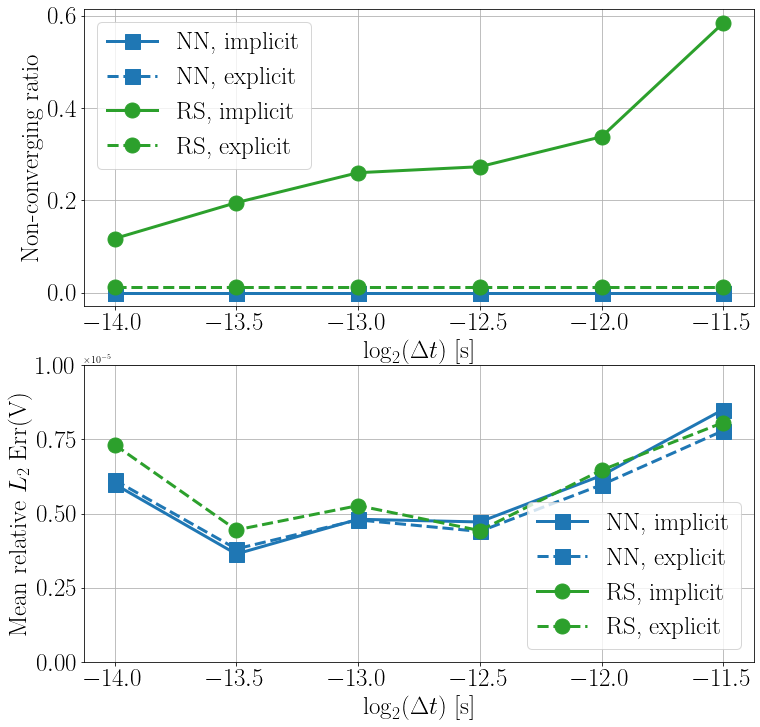

In [42]:
# Plot err vs. Nan ratio
fig, axs = plt.subplots(2, 1, figsize = (12, 12))

fsize = 25
rgs = [0, 6]

# Upper plot, plot NaN ratios
axs[0].tick_params(axis='both', which='major', labelsize=fsize)
for i in range(len(legends)):
    axs[0].plot(torch.log2(torch.tensor(data['step_sizes'])[rgs[0]:rgs[1]]), 
                V_nan_df.values.transpose()[rgs[0]:rgs[1], i], markers[i], markersize=15, linewidth=3.0, 
                color=colors[i], label=legends[i])
axs[0].set_xlabel("$\log_{2}(\Delta t)$ [s]", fontsize=fsize)
axs[0].set_ylabel("Non-converging ratio", fontsize=fsize)
axs[0].legend(loc='best', fontsize=fsize)
axs[0].grid()

axs[1].tick_params(axis='both', which='major', labelsize=fsize)
for i in range(len(legends)):
    axs[1].plot(torch.log2(torch.tensor(data['step_sizes'])[rgs[0]:rgs[1]]), 
                V_mean_df.values.transpose()[rgs[0]:rgs[1], i],markers[i], markersize=15, linewidth=3.0, 
                color=colors[i], label=legends[i])
axs[1].set_xlabel("$\log_{2}(\Delta t)$ [s]", fontsize=fsize)
axs[1].set_ylabel("Mean relative $L_2$ Err(V)", fontsize=fsize)
axs[1].set_ylim([0., 0.00001])
axs[1].legend(loc='best', fontsize=fsize)
axs[1].grid()

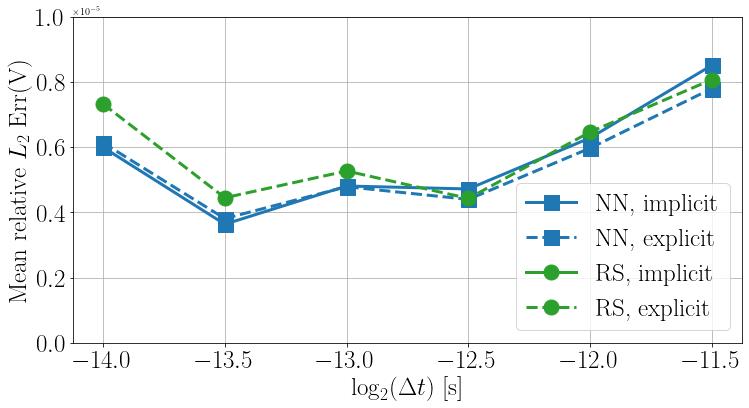

In [43]:
# Plot err vs. Nan ratio
fig, axs = plt.subplots(1, 1, figsize = (12, 6))

fsize = 25
rgs = [0, 6]

# # Upper plot, plot NaN ratios
# axs[0].tick_params(axis='both', which='major', labelsize=fsize)
# for i in range(len(legends)):
#     axs[0].plot(torch.log2(torch.tensor(data['step_sizes'])[rgs[0]:rgs[1]]), 
#                 V_nan_df.values.transpose()[rgs[0]:rgs[1], i], markers[i], markersize=15, linewidth=3.0, 
#                 color=colors[i], label=legends[i])
# axs[0].set_xlabel("$\log_{2}(\Delta t)$ [s]", fontsize=fsize)
# axs[0].set_ylabel("Non-converging ratio", fontsize=fsize)
# axs[0].legend(loc='best', fontsize=fsize)
# axs[0].grid()

axs.tick_params(axis='both', which='major', labelsize=fsize)
for i in range(len(legends)):
    axs.plot(torch.log2(torch.tensor(data['step_sizes'])[rgs[0]:rgs[1]]), 
                V_mean_df.values.transpose()[rgs[0]:rgs[1], i],markers[i], markersize=15, linewidth=3.0, 
                color=colors[i], label=legends[i])
axs.set_xlabel("$\log_{2}(\Delta t)$ [s]", fontsize=fsize)
axs.set_ylabel("Mean relative $L_2$ Err(V)", fontsize=fsize)
axs.set_ylim([0., 0.00001])
axs.legend(loc='best', fontsize=fsize)
axs.grid()

In [44]:
fig.savefig("./plots/pdf_figures/ErrGrowthDeltaT.pdf", format="pdf", bbox_inches="tight")

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

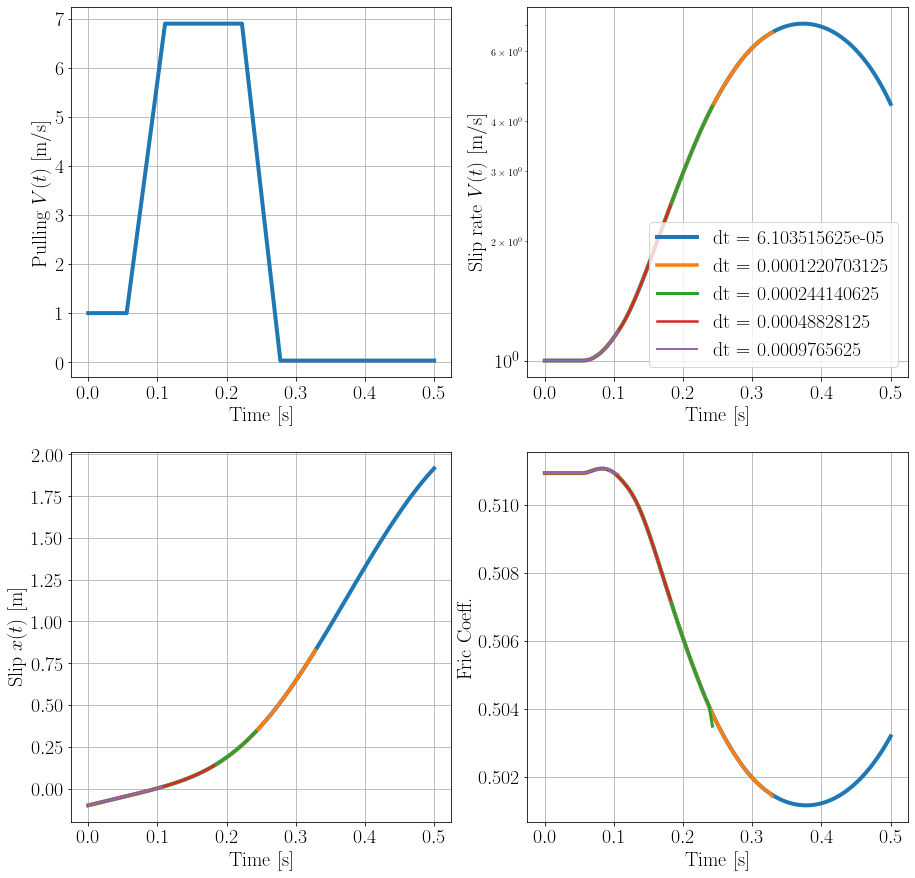

In [21]:
# Visualize simulation sequences
# Visualize results of rk solver on different step sizes
idx = 0
res = torch.load("./data/RSvsNNSpringSliderAcc0522_fine/res_RS_im_reg_seq_{0}.pth".format(idx))

plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'][rgs[0]:rgs[1]], 
              res['xs'][rgs[0]:rgs[1]], 
              res['Frics'][rgs[0]:rgs[1]], 
              ["dt = {0}".format(res['step_sizes'][i]) for i in range(rgs[0], rgs[1])])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

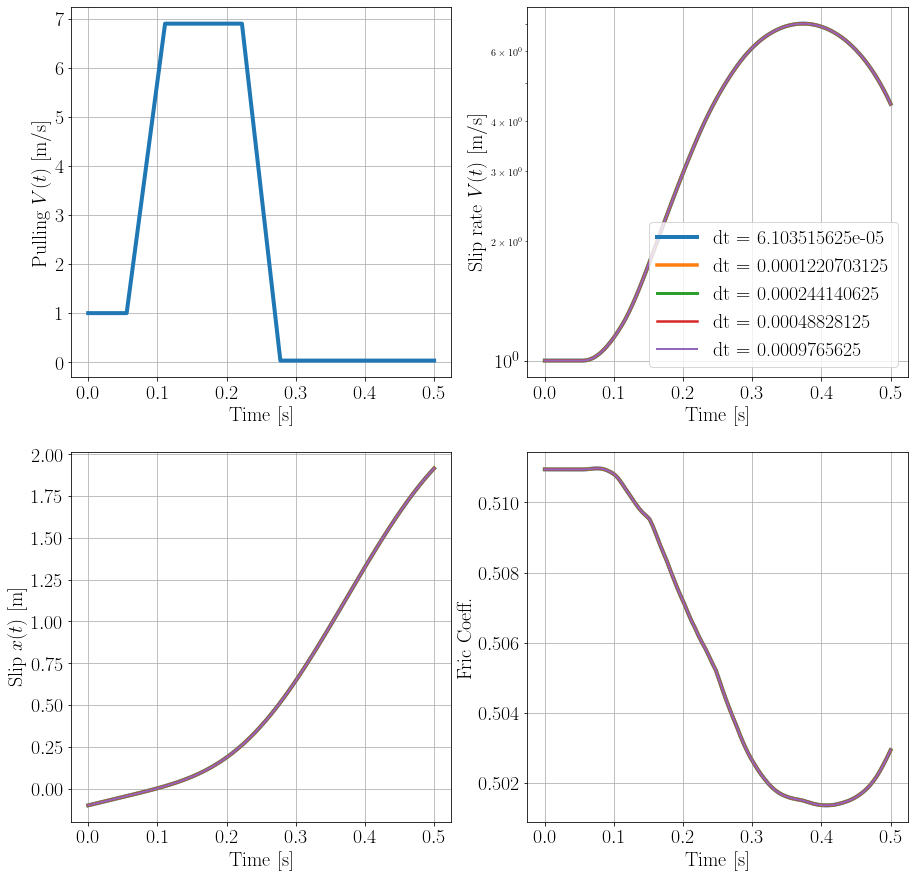

In [23]:
res = torch.load("./data/RSvsNNSpringSliderAcc0522_fine/res_NN_im_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'][rgs[0]:rgs[1]], 
              res['xs'][rgs[0]:rgs[1]], 
              res['Frics'][rgs[0]:rgs[1]], 
              ["dt = {0}".format(res['step_sizes'][i]) for i in range(rgs[0], rgs[1])])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

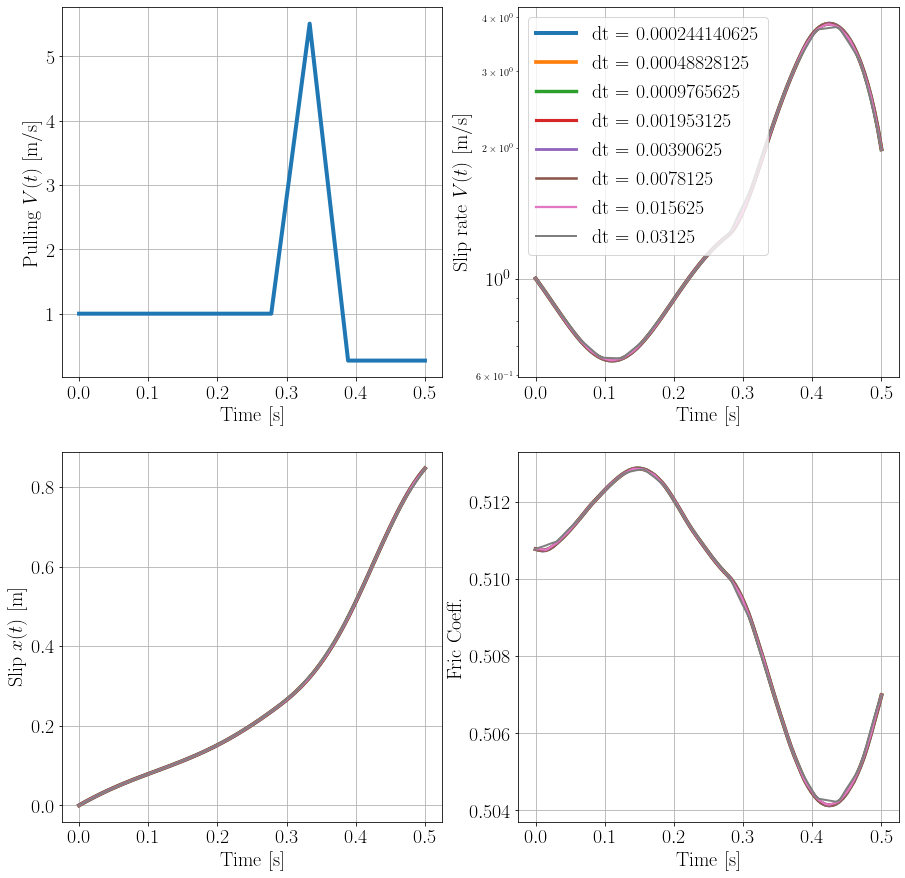

In [10]:
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_NN_ex_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

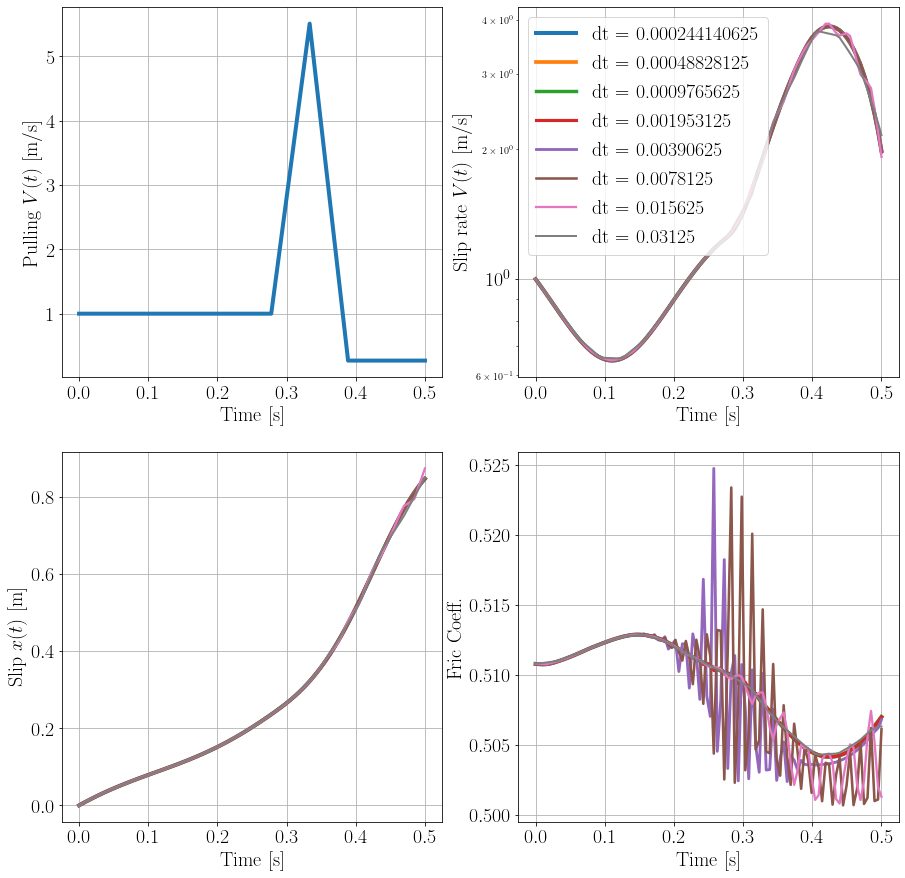

In [11]:
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_NN_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

In [ ]:
import pandas as pd
